<a href="https://colab.research.google.com/github/tsutsumi-ozro/NLP-100knocks/blob/main/ch08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

### 70. 単語ベクトルの和による特徴量
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch08.html)

問題50と同じことをする(閲覧している解答が変わっているため若干コードにも変化はあるが、やっていることはほとんど同じ)

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip

--2023-01-06 00:49:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  8.55MB/s    in 3.3s    

2023-01-06 00:49:23 (8.55 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=columns)

df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

問題60で使用した学習済み単語ベクトルをダウンロード

In [3]:
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2023-01-06 00:49:29--  https://docs.google.com/uc?export=download&confirm=&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 172.253.118.100, 172.253.118.138, 172.253.118.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7r2i97p4fbc04eff8t3suqpdhepoaplm/1672966125000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=86b68c1f-48c7-438a-bc99-df1e9cafa123 [following]
--2023-01-06 00:49:29--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7r2i97p4fbc04eff8t3suqpdhepoaplm/1672966125000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=86b68c1f-48c7-438a-bc99-df1e9cafa123
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 142.251.10.132, 2404:6800:40

In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

maketransはマッピングするのか<br>
https://www.w3big.com/ja/python/att-string-maketrans.html<br>
こちらstring<br>
https://docs.python.org/ja/3/library/string.html<br>
返り値はこれをしてる<br>

$\boldsymbol{x}_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})$


In [5]:
import string
import torch

def transform_w2v(text):
    #!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~を空白に置換しようとしてるわけ
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()
    #ここでベクトル変換してる
    vec = [model[word] for word in words if word in model]

    return torch.tensor(sum(vec)/len(vec))

In [6]:
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

In [7]:
category_dict = {'b':0, 't':1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

In [8]:
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

### 71. 単層ニューラルネットワークによる予測
※問題文に数式が含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch08.html)

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch+nn+linear#torch.nn.Linear<br>
https://pytorch.org/docs/stable/nn.init.html?highlight=nn+init+normal_#torch.nn.init.normal_<br>


In [9]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
    
    def forward(self, x):
        x = self.fc(x)
        return x

model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.0519, 0.1082, 0.4951, 0.3448]], grad_fn=<SoftmaxBackward0>)


In [10]:
y_hat = torch.softmax(model(X_train[:4]), dim=-1)
print(y_hat)

tensor([[0.0519, 0.1082, 0.4951, 0.3448],
        [0.3120, 0.2216, 0.2360, 0.2304],
        [0.0363, 0.1407, 0.6645, 0.1585],
        [0.7013, 0.0281, 0.1155, 0.1551]], grad_fn=<SoftmaxBackward0>)


### 72. 損失と勾配の計算
※問題文に数式が含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch08.html)

In [11]:
loss_fn = nn.CrossEntropyLoss()
loss_x1 = loss_fn(model(X_train[:1]), y_train[:1])
model.zero_grad()
loss_x1.backward()
print(f'損失: {loss_x1:.4f}')
print(f'勾配: \n{model.fc.weight.grad}')

損失: 2.9576
勾配: 
tensor([[ 0.0161, -0.1249,  0.0690,  ..., -0.0374, -0.0211, -0.0174],
        [-0.0018,  0.0143, -0.0079,  ...,  0.0043,  0.0024,  0.0020],
        [-0.0084,  0.0652, -0.0360,  ...,  0.0196,  0.0110,  0.0091],
        [-0.0058,  0.0454, -0.0251,  ...,  0.0136,  0.0077,  0.0063]])


In [12]:
loss_x1_to_x4 = loss_fn(model(X_train[:4]), y_train[:4])
model.zero_grad()
loss_x1_to_x4.backward()
print(f'損失: {loss_x1_to_x4:.4f}')
print(f'勾配: \n{model.fc.weight.grad}')

損失: 1.9482
勾配: 
tensor([[ 0.0407, -0.0279,  0.0351,  ..., -0.0083, -0.0259, -0.0069],
        [-0.0091,  0.0009, -0.0076,  ...,  0.0019,  0.0029, -0.0004],
        [-0.0201,  0.0137, -0.0152,  ...,  0.0022,  0.0186,  0.0065],
        [-0.0115,  0.0132, -0.0123,  ...,  0.0042,  0.0043,  0.0009]])


### 73.  確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．



In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return [self.X[index], self.y[index]]

dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [14]:
from torch.nn.modules.loss import CrossEntropyLoss

model = SLPNet(300, 4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train = loss_train / i

    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = loss_fn(outputs, labels)
    if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 10, loss_train: 0.5744, loss_valid: 0.5919
epoch: 20, loss_train: 0.4572, loss_valid: 0.4878
epoch: 30, loss_train: 0.4055, loss_valid: 0.4454
epoch: 40, loss_train: 0.3752, loss_valid: 0.4178
epoch: 50, loss_train: 0.3545, loss_valid: 0.4022
epoch: 60, loss_train: 0.3397, loss_valid: 0.3917
epoch: 70, loss_train: 0.3281, loss_valid: 0.3840
epoch: 80, loss_train: 0.3187, loss_valid: 0.3790
epoch: 90, loss_train: 0.3110, loss_valid: 0.3740
epoch: 100, loss_train: 0.3043, loss_valid: 0.3702


### 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [15]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            #sum? 0 or 1の出力だと思ってたけども.
            # argmaxのdocumentを読んで理解
            # https://pytorch.org/docs/stable/generated/torch.argmax.html?highlight=torch+argmax#torch.argmax
            correct += (pred==labels).sum().item()
    return correct / total

acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'train accuracy score: {acc_train:.3f}')
print(f'test accuracy score：{acc_test:.3f}')

train accuracy score: 0.894
test accuracy score：0.889


### 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [16]:
def calculate_loss_and_accuracy(model, loss_fn, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += loss_fn(outputs, labels)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred==labels).sum().item()
    return loss/len(loader), correct/total

In [17]:
model = SLPNet(300, 4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 100
log_train = []
log_valid = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    loss_train, acc_train = calculate_loss_and_accuracy(model, loss_fn, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, loss_fn, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 10, loss_train: 0.5698, accuracy_train: 0.7939, loss_valid: 0.6075, accuracy_valid: 0.7729
epoch: 20, loss_train: 0.4556, accuracy_train: 0.8369, loss_valid: 0.4891, accuracy_valid: 0.8328
epoch: 30, loss_train: 0.4042, accuracy_train: 0.8559, loss_valid: 0.4353, accuracy_valid: 0.8546
epoch: 40, loss_train: 0.3738, accuracy_train: 0.8663, loss_valid: 0.4039, accuracy_valid: 0.8621
epoch: 50, loss_train: 0.3539, accuracy_train: 0.8748, loss_valid: 0.3828, accuracy_valid: 0.8673
epoch: 60, loss_train: 0.3390, accuracy_train: 0.8808, loss_valid: 0.3675, accuracy_valid: 0.8733
epoch: 70, loss_train: 0.3278, accuracy_train: 0.8853, loss_valid: 0.3558, accuracy_valid: 0.8778
epoch: 80, loss_train: 0.3183, accuracy_train: 0.8884, loss_valid: 0.3464, accuracy_valid: 0.8831
epoch: 90, loss_train: 0.3110, accuracy_train: 0.8923, loss_valid: 0.3387, accuracy_valid: 0.8846
epoch: 100, loss_train: 0.3047, accuracy_train: 0.8943, loss_valid: 0.3321, accuracy_valid: 0.8876


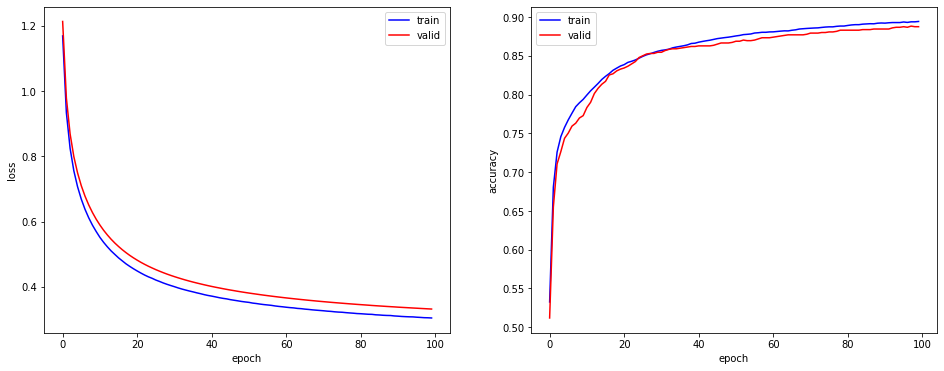

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(np.array(log_train).T[0], label='train', color='blue')
ax[0].plot(np.array(log_valid).T[0], label='valid', color='red')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(np.array(log_train).T[1], label='train', color='blue')
ax[1].plot(np.array(log_valid).T[1], label='valid', color='red')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

### 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [19]:
model = SLPNet(300, 4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 100
log_train = []
log_valid = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    loss_train, acc_train = calculate_loss_and_accuracy(model, loss_fn, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, loss_fn, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')
    if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 10, loss_train: 0.5665, accuracy_train: 0.7927, loss_valid: 0.5958, accuracy_valid: 0.8013
epoch: 20, loss_train: 0.4559, accuracy_train: 0.8323, loss_valid: 0.4877, accuracy_valid: 0.8313
epoch: 30, loss_train: 0.4056, accuracy_train: 0.8541, loss_valid: 0.4382, accuracy_valid: 0.8508
epoch: 40, loss_train: 0.3754, accuracy_train: 0.8665, loss_valid: 0.4087, accuracy_valid: 0.8583
epoch: 50, loss_train: 0.3552, accuracy_train: 0.8743, loss_valid: 0.3887, accuracy_valid: 0.8673
epoch: 60, loss_train: 0.3404, accuracy_train: 0.8796, loss_valid: 0.3741, accuracy_valid: 0.8688
epoch: 70, loss_train: 0.3293, accuracy_train: 0.8845, loss_valid: 0.3628, accuracy_valid: 0.8718
epoch: 80, loss_train: 0.3201, accuracy_train: 0.8878, loss_valid: 0.3538, accuracy_valid: 0.8748
epoch: 90, loss_train: 0.3124, accuracy_train: 0.8912, loss_valid: 0.3463, accuracy_valid: 0.8778
epoch: 100, loss_train: 0.3060, accuracy_train: 0.8937, loss_valid: 0.3400, accuracy_valid: 0.8786


### 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [20]:
import time
def train_model(datset_train, datset_valid, batch_size, model, loss_fn, optimizer, num_epochs):
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        s_time = time.time()
        model.train()
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_trian, acc_train = calculate_loss_and_accuracy(model, loss_fn, dataloader_train)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, loss_fn, dataloader_valid)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')

        e_time = time.time()
        #if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [21]:
b = [2**n for n in range(1, 6)]

dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

for batch_size in b:
    num_epoch = 1
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, num_epoch)

バッチサイズ: 2
epoch: 1, loss_train: 0.3060, accuracy_train: 0.8990, loss_valid: 0.3271, accuracy_valid: 0.8846, 2.1223sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3060, accuracy_train: 0.9017, loss_valid: 0.3219, accuracy_valid: 0.8891, 1.1606sec
バッチサイズ: 8
epoch: 1, loss_train: 0.3060, accuracy_train: 0.9014, loss_valid: 0.3173, accuracy_valid: 0.8883, 0.6154sec
バッチサイズ: 16
epoch: 1, loss_train: 0.3060, accuracy_train: 0.9023, loss_valid: 0.3159, accuracy_valid: 0.8913, 0.3772sec
バッチサイズ: 32
epoch: 1, loss_train: 0.3060, accuracy_train: 0.9022, loss_valid: 0.3194, accuracy_valid: 0.8891, 0.2404sec


### 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [32]:
#以前作成した関数にdeviceを追加

def calculate_loss_and_accuracy(model, loss_fn, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += loss_fn(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

def train_model(datset_train, datset_valid, batch_size, model, loss_fn, optimizer, num_epochs, device=None):
    model.to(device)
    
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()

        for inputs, labels in dataloader_train:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_trian, acc_train = calculate_loss_and_accuracy(model, loss_fn, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, loss_fn, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')

        e_time = time.time()
        #if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SLPNet(300, 4)
for batch_size in b:
    num_epoch = 1
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, num_epoch, device)

バッチサイズ: 2
epoch: 1, loss_train: 0.3060, accuracy_train: 0.2013, loss_valid: 2.6435, accuracy_valid: 0.2009, 5.0048sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3060, accuracy_train: 0.2013, loss_valid: 2.6442, accuracy_valid: 0.2009, 2.5115sec
バッチサイズ: 8
epoch: 1, loss_train: 0.3060, accuracy_train: 0.2013, loss_valid: 2.6431, accuracy_valid: 0.2009, 1.3639sec
バッチサイズ: 16
epoch: 1, loss_train: 0.3060, accuracy_train: 0.2013, loss_valid: 2.6444, accuracy_valid: 0.2009, 0.7108sec
バッチサイズ: 32
epoch: 1, loss_train: 0.3060, accuracy_train: 0.2013, loss_valid: 2.6451, accuracy_valid: 0.2009, 0.4320sec


### 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html<br>
https://smile-jsp.hateblo.jp/entry/2020/06/23/001147

In [51]:
from torch.nn import functional as F

class MLPNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size, mid_layers):
        super().__init__()
        self.mid_layers = mid_layers
        self.fc = nn.Linear(input_size, mid_size)
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, output_size)
        self.bn = nn.BatchNorm1d(mid_size)
    
    def forward(self, x):
        x = F.relu(self.fc(x))
        for _ in range(self.mid_layers):
            x = F.relu(self.bn(self.fc_mid(x)))
        x = F.relu(self.fc_out(x))

        return x

In [52]:
from torch import optim

def train_model(datset_train, datset_valid, batch_size, model, loss_fn, optimizer, num_epochs, device=None):
    model.to(device)
    
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

    #スケジューラの設定を行う
    #https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()

        for inputs, labels in dataloader_train:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_trian, acc_train = calculate_loss_and_accuracy(model, loss_fn, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, loss_fn, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')

        e_time = time.time()
        #if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        if epoch > 3 and log_valid[epoch-3][0]  <= log_valid[epoch-2][0] <= log_valid[epoch-1][0]<= log_valid[epoch][0]:
            break
        
        scheduler.step()
    return {'train': log_train, 'valid': log_valid}

In [53]:
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

model = MLPNet(300, 200, 4, 1)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

log = train_model(dataset_train, dataset_valid, 64, model, loss_fn, optimizer, 1000, device)

epoch: 1, loss_train: 0.3060, accuracy_train: 0.7463, loss_valid: 0.9865, accuracy_valid: 0.7361, 0.4264sec
epoch: 2, loss_train: 0.3060, accuracy_train: 0.7759, loss_valid: 0.7490, accuracy_valid: 0.7751, 0.4365sec
epoch: 3, loss_train: 0.3060, accuracy_train: 0.7824, loss_valid: 0.6688, accuracy_valid: 0.7804, 0.4342sec
epoch: 4, loss_train: 0.3060, accuracy_train: 0.7884, loss_valid: 0.6257, accuracy_valid: 0.7849, 0.4435sec
epoch: 5, loss_train: 0.3060, accuracy_train: 0.7987, loss_valid: 0.5905, accuracy_valid: 0.7991, 0.4263sec
epoch: 6, loss_train: 0.3060, accuracy_train: 0.8112, loss_valid: 0.5587, accuracy_valid: 0.8088, 0.4502sec
epoch: 7, loss_train: 0.3060, accuracy_train: 0.8195, loss_valid: 0.5301, accuracy_valid: 0.8178, 0.4498sec
epoch: 8, loss_train: 0.3060, accuracy_train: 0.8337, loss_valid: 0.5028, accuracy_valid: 0.8328, 0.4398sec
epoch: 9, loss_train: 0.3060, accuracy_train: 0.8428, loss_valid: 0.4813, accuracy_valid: 0.8448, 0.4401sec
epoch: 10, loss_train: 0.306

In [55]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [57]:
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'train accuracy_score：{acc_train:.3f}')
print(f'test accuracy_score：{acc_test:.3f}')

train accuracy_score：0.954
test accuracy_score：0.915
